### TODO List:
To prepare the data, following the needs identified before, with respect to:
- Encoding.
- Missing value imputation.
- Outliers treatment.
- Scaling.
- Balancing.
- Feature selection and generation.

For each preparation task:
1. Pick the dataset and split it into two datasets: one for training and another for testing.
1. For each preparation task, choose two different approaches and apply them to the training
dataset. Then apply the adequate transformation to the testing set, when necessary.
1. Train a KNN and a Naïve Bayes model for each resulting dataset.
1. Compare the performance of both Naïve Bayes and both KNN models and select the dataset
that yields the best performance.
1. Pick this dataset to proceed to the next preparation task.

[Lab functions documentation](https://web.ist.utl.pt/~claudia.antunes/DSLabs/)

[Dataset description](https://www.kaggle.com/datasets/oktayrdeki/traffic-accidents)

#### Methodology

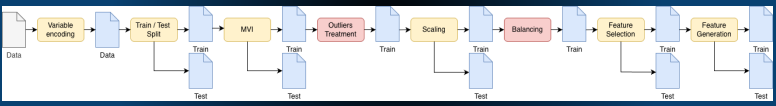

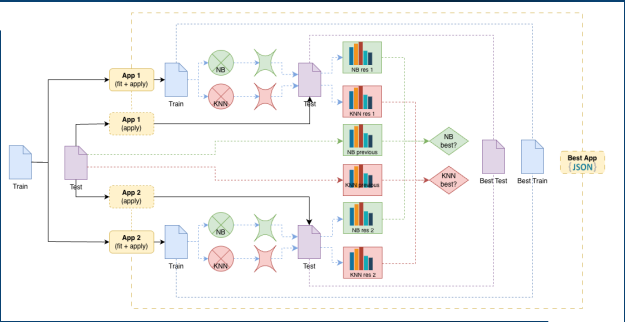

#### Encoding
Ordinal enconding:
- damage
- most_severe_injury
- weather_condition
- lighting_condition
- roadway_surface_cond

One-hot encoding:
- alignment
- traffic_control_device
- trafficway_type
- road_defect
- prim_contributory_cause
- first_crash_type

Cyclic encoding:
- crash_date_year
- crash_date_quarter
- crash_date_month
- crash_date_day

#### Missing Values
No need because there are no missing values

#### Outliers
- Dropping outliers
- Replacing outliers with fixed value (p99)
- Truncating outliers


#### Best strategies:
- Encoding
    - TODO
- Outliers
    - fixed (median)
- Scaling
    - NB: minmax
    - KNN: zscore

In [1]:
from numpy import ndarray
from pandas import DataFrame, read_csv, Series, to_numeric, to_datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib.pyplot import savefig, show, figure
from dslabs_functions import plot_multibar_chart, CLASS_EVAL_METRICS, run_NB, run_KNN, encode_cyclic_variables, dummify, determine_outlier_thresholds_for_var

In [2]:
filename = "data/traffic_accidents.csv"
sample = True
target = "crash_type"
file_tag = "traffic_accidents"
outlier_strategy="fixed"
scaling_strategy = "zscore"
flag_outliers = False
flag_scaling = False
flags = [flag_outliers, flag_scaling]

In [ ]:
def load_dataset(filename: str, sample: bool = False) -> DataFrame:
    df: DataFrame = read_csv(filename, na_values="")
    print(f'Loading dataset from {filename}...')
    if sample:
        df = df.sample(frac=0.3, random_state=42)
        print(f'Sampling 30% of the dataset for quicker processing...')
    return df

def get_variable_types(df: DataFrame) -> dict[str, list]:
    variable_types: dict = {"numeric": [], "binary": [], "date": [], "symbolic": []}

    nr_values: Series = df.nunique(axis=0, dropna=True)
    for c in df.columns:
        if 2 == nr_values[c]:
            variable_types["binary"].append(c)
            df[c].astype("bool")
        else:
            try:
                to_numeric(df[c], errors="raise")
                if "crash" in c:
                    print(f"Column {c} seems numeric but is actually symbolic.")
                    variable_types["symbolic"].append(c)
                else:
                    variable_types["numeric"].append(c)
            except ValueError:
                try:
                    df[c] = to_datetime(df[c], errors="raise")
                    variable_types["date"].append(c)
                except ValueError:
                    variable_types["symbolic"].append(c)
    return variable_types

def derive_date_variables(df: DataFrame, date_vars: list[str]) -> DataFrame:
    for date in date_vars:
        df[f"{date}_year"] = df[date].dt.year
        df[f"{date}_quarter"] = df[date].dt.quarter
        df[f"{date}_month"] = df[date].dt.month
        df[f"{date}_day"] = df[date].dt.day
    df.drop(columns=date_vars, inplace=True)
    return df

def evaluate_approach(train: DataFrame, test: DataFrame, target: str = "class", metric: str = "accuracy") -> dict[str, list]:
    trnY = train.pop(target).values
    trnX: ndarray = train.values
    tstY = test.pop(target).values
    tstX: ndarray = test.values
    eval: dict[str, list] = {}

    eval_NB: dict[str, float] = run_NB(trnX, trnY, tstX, tstY, metric=metric)
    eval_KNN: dict[str, float] = run_KNN(trnX, trnY, tstX, tstY, metric=metric)
    if eval_NB != {} and eval_KNN != {}:
        for met in CLASS_EVAL_METRICS:
            eval[met] = [eval_NB[met], eval_KNN[met]]

    return eval

def process_outliers(df: DataFrame, strategy: str = "discard") -> tuple[DataFrame, bool]:
    print(f"Shape of original data: {df.shape}")
    file_tag = "traffic_accidents"
    variable_types = get_variable_types(df)
    numeric_vars: list[str] = variable_types["numeric"] + variable_types["binary"]
    if numeric_vars:
        if strategy == "discard":
            df = discard_outliers(df, file_tag, numeric_vars)
        elif strategy == "truncate":
            df = truncate_outliers(df, file_tag, numeric_vars)
        else:
            df = replace_fixed_outliers(df, file_tag, numeric_vars)
        print(f"Shape after performing outlier processing with {strategy} strategy: {df.shape}")
    else:
        print("There are no numeric or binary variables to process.")
    return df, True

def discard_outliers(df: DataFrame, file_tag: str, numeric_vars: list[str]) -> DataFrame:
    summary5: DataFrame = df[numeric_vars].describe()
    for var in numeric_vars:
        top, bottom = determine_outlier_thresholds_for_var(summary5[var])
        outliers: Series = df[(df[var] > top) | (df[var] < bottom)]
        df = df.drop(outliers.index, axis=0, inplace=False)

    df.to_csv(f"lab3/data/{file_tag}_train_drop_outliers.csv", index=True)
    return df

def truncate_outliers(df: DataFrame, file_tag: str, numeric_vars: list[str]) -> DataFrame:
    summary5: DataFrame = df[numeric_vars].describe()
    for var in numeric_vars:
        top, bottom = determine_outlier_thresholds_for_var(summary5[var])
        df[var] = df[var].apply(lambda x: top if x > top else bottom if x < bottom else x)

    df.to_csv(f"lab3/data/{file_tag}_train_truncate_outliers.csv", index=True)
    return df

def replace_fixed_outliers(df: DataFrame, file_tag: str, numeric_vars: list[str]) -> DataFrame:
    summary5: DataFrame = df[numeric_vars].describe()
    for var in numeric_vars:
        top, bottom = determine_outlier_thresholds_for_var(summary5[var])
        median: float = df[var].median()
        df[var] = df[var].apply(lambda x: median if x > top or x < bottom else x)

    df.to_csv(f"lab3/data/{file_tag}_train_fixed_outliers.csv", index=True)
    return df

def ordinal_encoding(df: DataFrame):
    damage_values: dict[str, int] = {
        "$500 OR LESS": 0,
        "$501 - $1,500": 1,
        "OVER $1,500": 2,
    }
    most_severe_injury_values: dict[str, int] = {
        "NO INDICATION OF INJURY": 0,
        "REPORTED, NOT EVIDENT": 1,
        "NONINCAPACITATING INJURY": 2,
        "INCAPACITATING INJURY": 3,
        "FATAL": 4,
    }
    weather_condition_values: dict[str, int] = {
        "CLEAR": 0,
        "CLOUDY/OVERCAST": 1,
        "FOG/SMOKE/HAZE": 2,
        "RAIN": 3,
        "SLEET/HAIL": 4,
        "SNOW": 5,
        "BLOWING SNOW": 6,
        "FREEZING RAIN/DRIZZLE": 7,
        "BLOWING SAND, SOIL, DIRT": 8,
        "SEVERE CROSS WIND GATE": 9,
        "OTHER": 10,
        "UNKNOWN": 11,
    }
    # Order lighting conditions from darkest to brightest; keep unknown last for clarity.
    lighting_condition_values: dict[str, int] = {
        "DARKNESS": 0,
        "DARKNESS, LIGHTED ROAD": 1,
        "DAWN": 2,
        "DAYLIGHT": 3,
        "DUSK": 4,
        "UNKNOWN": 5,
    }

    roadway_surface_cond_values: dict[str, int] = {
        "DRY": 0,
        "WET": 1,
        "SNOW OR SLUSH": 2,
        "SAND, MUD, DIRT": 3,
        "ICE": 4,
        "OTHER": 5,
        "UNKNOWN": 6,
    }

    ordinal_encoding: dict[str, dict[str, int]] = {
        "damage": damage_values,
        #"most_severe_injury": most_severe_injury_values,
        #"weather_condition": weather_condition_values,
        "lighting_condition": lighting_condition_values,
        "roadway_surface_cond": roadway_surface_cond_values,
    }

    return df.replace(ordinal_encoding, inplace=False)

def one_hot_encoding(df: DataFrame) -> DataFrame:
    vars: list[str] = [
        "alignment",
        "traffic_control_device",
        "trafficway_type",
        "road_defect",
        "prim_contributory_cause",
        "first_crash_type",
        "weather_condition",
    ]
    return dummify(df, vars)

def cyclic_encoding(df: DataFrame) -> DataFrame:
    df = derive_date_variables(df, ["crash_date"])
    cyclic_vars = [
        "crash_date_year",
        "crash_date_quarter",
        "crash_date_month",
        "crash_date_day"
    ]
    encode_cyclic_variables(df, cyclic_vars)
    return df

def binary_encoding(df: DataFrame) -> DataFrame:
    crash_type_values: dict[str, int] = {
        "NO INJURY / DRIVE AWAY": 0,
        "INJURY AND / OR TOW DUE TO CRASH": 1,
    }

    intersection_related_i_values: dict[str, int] = {
        "N": 0,
        "Y": 1,
    }

    binary_encoding = {
        "crash_type": crash_type_values,
        "intersection_related_i": intersection_related_i_values,
    }

    bool_cols = df.select_dtypes(include="bool").columns
    df[bool_cols] = df[bool_cols].astype("int8")

    return df.replace(binary_encoding, inplace=False)

def data_encoding(df: DataFrame) -> DataFrame:
    df = ordinal_encoding(df)
    df = one_hot_encoding(df)
    df = cyclic_encoding(df)
    df = binary_encoding(df)
    return df

def data_scaling(dfs: list[DataFrame], file_tag: str, target: str, strategy: str = "zscore") -> tuple[DataFrame, DataFrame, bool]:
    for i, df in enumerate(dfs):
        features = df.drop(columns=[target], inplace=False)
        target_data: Series = df[target]
        if strategy == "minmax":
            scaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(features)
        else:
            scaler = StandardScaler(with_mean=True, with_std=True, copy=True).fit(features)
        df_transf = DataFrame(scaler.transform(features), index=df.index, columns=features.columns)
        df_transf[target] = target_data.values
        if i == 0:
            train_df_transf = df_transf
            df_transf.to_csv(f"lab3/data/{file_tag}_train_scaled_{strategy}.csv", index="id")
        else:
            test_df_transf = df_transf
            df_transf.to_csv(f"lab3/data/{file_tag}_test_scaled_{strategy}.csv", index="id")

    return train_df_transf, test_df_transf, True

def split_train_test_data(df: DataFrame, test_size: float = 0.3) -> tuple[DataFrame, DataFrame]:
    train_df = df.sample(frac=1-test_size, random_state=42)
    test_df = df.drop(train_df.index)
    print(f'Train shape: {train_df.shape}, Test shape: {test_df.shape}')
    train_df.to_csv("lab3/data/traffic_accidents_train.csv", index=False)
    test_df.to_csv("lab3/data/traffic_accidents_test.csv", index=False)

    return train_df, test_df

def evaluate(train_df: DataFrame, test_df: DataFrame, file_tag: str, target: str, outlier_strategy: str, scaling_strategy: str, flags: list[bool]):
    train_cp = train_df.copy(deep=True)
    test_cp = test_df.copy(deep=True)
    label = ""
    title_label = ""
    
    if flags[0]:
        label += (f"_{outlier_strategy}_outlier")
    if flags[1]:
        label += (f"_{scaling_strategy}_scaling")

    if flags[0]:
        if outlier_strategy == "fixed":
            title_label = "(replacing outliers)"
        if outlier_strategy == "truncate":
            title_label = "(truncating outliers)"
    if flags[1]:
        if scaling_strategy == "zscore":
            title_label = "(scaling z-score)"
        if scaling_strategy == "minmax":
            title_label = "(scaling min-max)"        

    figure()
    eval: dict[str, list] = evaluate_approach(train_cp, test_cp, target=target, metric="recall")
    plot_multibar_chart(["NB", "KNN"], eval, title=f"{file_tag} evaluation {title_label}", percentage=True)
    savefig(f"images/{file_tag}_eval{label}.png")
    show()

## Load Dataset

In [4]:
df = load_dataset(filename, sample=sample)
vars: dict[str, list] = get_variable_types(df)
for var in vars:
    print(f'{var} variables: {vars[var]}')
for c in vars["symbolic"]:
    print(f'"{c}" has {len(df[c].unique())} distinct values: {df[c].unique()}')

Loading dataset from data/traffic_accidents.csv...
Sampling 30% of the dataset for quicker processing...
Column crash_hour seems numeric but is actually symbolic.
Column crash_day_of_week seems numeric but is actually symbolic.
Column crash_month seems numeric but is actually symbolic.
numeric variables: ['num_units', 'injuries_total', 'injuries_fatal', 'injuries_incapacitating', 'injuries_non_incapacitating', 'injuries_reported_not_evident', 'injuries_no_indication']
binary variables: ['crash_type', 'intersection_related_i']
date variables: ['crash_date']
symbolic variables: ['traffic_control_device', 'weather_condition', 'lighting_condition', 'first_crash_type', 'trafficway_type', 'alignment', 'roadway_surface_cond', 'road_defect', 'damage', 'prim_contributory_cause', 'most_severe_injury', 'crash_hour', 'crash_day_of_week', 'crash_month']
"traffic_control_device" has 19 distinct values: ['TRAFFIC SIGNAL' 'NO CONTROLS' 'OTHER' 'STOP SIGN/FLASHER' 'UNKNOWN'
 'FLASHING CONTROL SIGNAL' '

Column crash_date seems numeric but is actually symbolic.
Column crash_hour seems numeric but is actually symbolic.
Column crash_day_of_week seems numeric but is actually symbolic.
Column crash_month seems numeric but is actually symbolic.
Train shape: (43954, 2), Test shape: (18838, 2)


,num_units,crash_type
17526,1,1
164873,1,0
200603,2,1
77819,2,0
102927,2,1


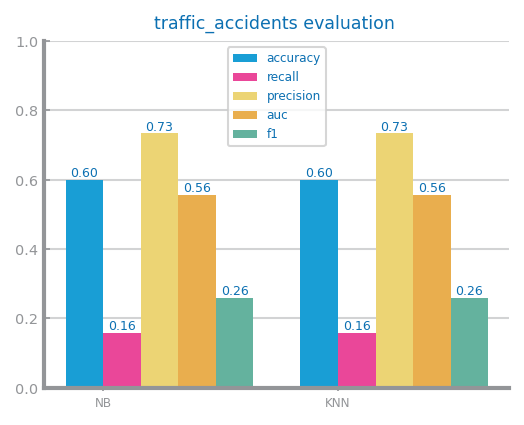

In [5]:
#encode target column as binary
df[target] = df[target].apply(lambda x: 1 if x == "INJURY AND / OR TOW DUE TO CRASH" else 0)
df.drop(df.filter(regex='injur').columns, axis=1, inplace=True)
vars: dict[str, list] = get_variable_types(df)
train_df, test_df = split_train_test_data(df[vars["numeric"]+[target]])
display(train_df.head())
flags = [False, False]
evaluate(train_df, test_df, file_tag, target, outlier_strategy, scaling_strategy, flags)

In [8]:
for c in df.columns:
    print(c + str(df[c].unique()))

crash_date<DatetimeArray>
['2018-06-01 15:30:00', '2018-07-19 11:43:00', '2024-07-04 10:40:00',
 '2018-10-13 15:00:00', '2024-07-18 13:36:00', '2021-07-12 15:30:00',
 '2018-04-30 15:30:00', '2021-07-20 21:00:00', '2022-04-06 11:00:00',
 '2022-08-28 13:45:00',
 ...
 '2024-06-09 01:41:00', '2019-04-28 01:22:00', '2021-04-21 04:56:00',
 '2022-11-04 10:53:00', '2018-05-02 14:40:00', '2021-01-05 07:11:00',
 '2022-10-25 04:00:00', '2023-06-09 14:50:00', '2020-05-09 15:45:00',
 '2021-03-05 21:18:00']
Length: 60753, dtype: datetime64[ns]
traffic_control_device['TRAFFIC SIGNAL' 'NO CONTROLS' 'OTHER' 'STOP SIGN/FLASHER' 'UNKNOWN'
 'FLASHING CONTROL SIGNAL' 'LANE USE MARKING' 'PEDESTRIAN CROSSING SIGN'
 'YIELD' 'OTHER REG. SIGN' 'OTHER WARNING SIGN' 'RAILROAD CROSSING GATE'
 'NO PASSING' 'DELINEATORS' 'OTHER RAILROAD CROSSING' 'POLICE/FLAGMAN'
 'SCHOOL ZONE' 'RR CROSSING SIGN' 'BICYCLE CROSSING SIGN']
weather_condition['CLEAR' 'CLOUDY/OVERCAST' 'RAIN' 'UNKNOWN' 'SNOW' 'FREEZING RAIN/DRIZZLE'
 'OT

## Encoding

Column crash_hour seems numeric but is actually symbolic.
Column crash_day_of_week seems numeric but is actually symbolic.
Column crash_month seems numeric but is actually symbolic.
Column crash_date_year seems numeric but is actually symbolic.
Column crash_date_quarter seems numeric but is actually symbolic.
Column crash_date_month seems numeric but is actually symbolic.
Column crash_date_day seems numeric but is actually symbolic.
Column crash_date_year_sin seems numeric but is actually symbolic.
Column crash_date_year_cos seems numeric but is actually symbolic.
Column crash_date_quarter_sin seems numeric but is actually symbolic.
Column crash_date_quarter_cos seems numeric but is actually symbolic.
Column crash_date_month_sin seems numeric but is actually symbolic.
Column crash_date_month_cos seems numeric but is actually symbolic.
Column crash_date_day_sin seems numeric but is actually symbolic.
Column crash_date_day_cos seems numeric but is actually symbolic.
numeric variables: ['

,lighting_condition,roadway_surface_cond,crash_type,intersection_related_i,damage,num_units,most_severe_injury,crash_hour,crash_day_of_week,crash_month,...,crash_date_month,crash_date_day,crash_date_year_sin,crash_date_year_cos,crash_date_quarter_sin,crash_date_quarter_cos,crash_date_month_sin,crash_date_month_cos,crash_date_day_sin,crash_date_day_cos
17526,1,0,1,1,2,1,2,21,1,3,...,3,18,-0.022,1.0,1.0,0.0,1.000,0.0,-0.485,-0.874
164873,3,0,0,1,2,1,0,17,3,3,...,3,28,-0.025,1.0,1.0,0.0,1.000,0.0,-0.571,0.821
200603,3,0,1,1,1,2,1,17,5,9,...,9,19,-0.003,1.0,-1.0,-0.0,-1.000,-0.0,-0.651,-0.759
77819,3,1,0,1,2,2,0,11,6,8,...,8,12,-0.028,1.0,-1.0,-0.0,-0.866,-0.5,0.651,-0.759
102927,1,0,1,1,2,2,0,20,6,3,...,3,11,-0.009,1.0,1.0,0.0,1.000,0.0,0.791,-0.612


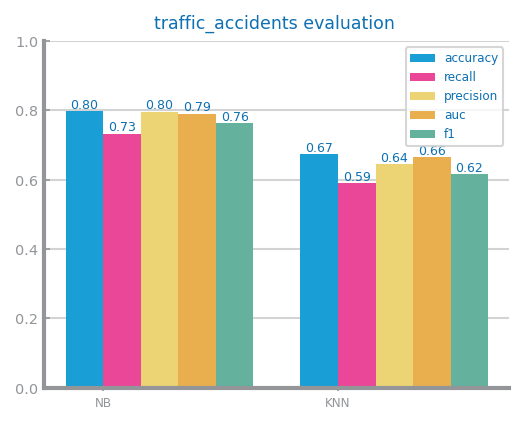

In [20]:
df = data_encoding(df)
vars = get_variable_types(df)
for var in vars:
    print(f'{var} variables: {vars[var]}')
for c in vars["symbolic"]:
    print(f'"{c}" has {len(df[c].unique())} distinct values: {df[c].unique()}')

train_df, test_df = split_train_test_data(df)
display(train_df.head())
evaluate(train_df, test_df, file_tag, target, outlier_strategy, scaling_strategy, flags)

## Outliers

Shape of original data: (43954, 143)
Column crash_hour seems numeric but is actually symbolic.
Column crash_day_of_week seems numeric but is actually symbolic.
Column crash_month seems numeric but is actually symbolic.
Column crash_date_year seems numeric but is actually symbolic.
Column crash_date_quarter seems numeric but is actually symbolic.
Column crash_date_month seems numeric but is actually symbolic.
Column crash_date_day seems numeric but is actually symbolic.
Column crash_date_year_sin seems numeric but is actually symbolic.
Column crash_date_year_cos seems numeric but is actually symbolic.
Column crash_date_quarter_sin seems numeric but is actually symbolic.
Column crash_date_quarter_cos seems numeric but is actually symbolic.
Column crash_date_month_sin seems numeric but is actually symbolic.
Column crash_date_month_cos seems numeric but is actually symbolic.
Column crash_date_day_sin seems numeric but is actually symbolic.
Column crash_date_day_cos seems numeric but is act

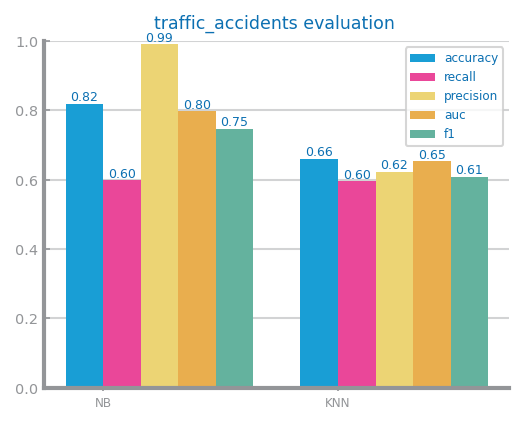

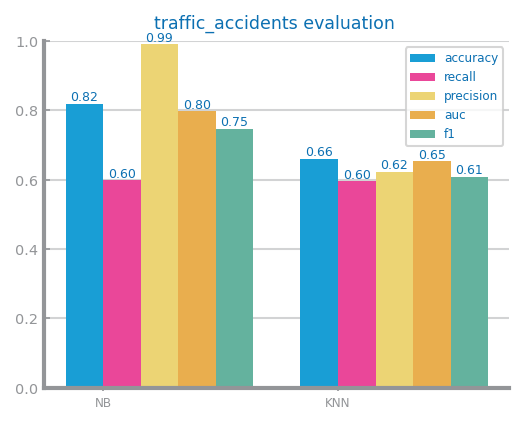

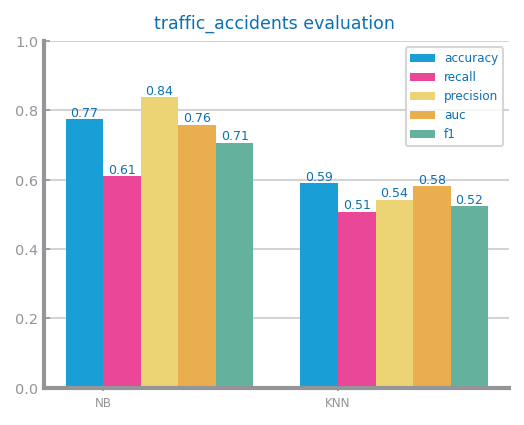

In [21]:
train_df_truncate, flag_outliers = process_outliers(train_df, strategy="truncate")
train_df_fixed, flag_outliers = process_outliers(train_df, strategy="fixed")
train_df_discard, flag_outliers = process_outliers(train_df, strategy="discard")
evaluate(train_df_truncate, test_df, file_tag, target, "truncate", scaling_strategy, flags)
evaluate(train_df_fixed, test_df, file_tag, target, "fixed", scaling_strategy, flags)
evaluate(train_df_discard, test_df, file_tag, target, "discard", scaling_strategy, flags)

In [22]:
df.head()

,lighting_condition,roadway_surface_cond,crash_type,intersection_related_i,damage,num_units,most_severe_injury,crash_hour,crash_day_of_week,crash_month,...,crash_date_month,crash_date_day,crash_date_year_sin,crash_date_year_cos,crash_date_quarter_sin,crash_date_quarter_cos,crash_date_month_sin,crash_date_month_cos,crash_date_day_sin,crash_date_day_cos
142002,3,0,0,1,2,2,0,15,6,6,...,6,1,-0.022,1.0,0.0,-1.0,0.000,-1.000,0.201,0.980
132434,3,0,1,1,1,2,0,11,5,7,...,7,19,-0.022,1.0,-1.0,-0.0,-0.500,-0.866,-0.651,-0.759
106970,3,6,1,1,1,2,2,10,5,7,...,7,4,-0.003,1.0,-1.0,-0.0,-0.500,-0.866,0.725,0.689
64659,3,0,0,1,1,2,0,15,7,10,...,10,13,-0.022,1.0,-0.0,1.0,-0.866,0.500,0.485,-0.874
107577,3,0,1,1,2,2,3,13,5,7,...,7,18,-0.003,1.0,-1.0,-0.0,-0.500,-0.866,-0.485,-0.874


## Scaling

In [8]:
train_df_t_zscore, test_df_t_zscore, flag_scaling = data_scaling([train_df_truncate, test_df], file_tag, target, strategy="zscore")
train_df_f_zscore, test_df_f_zscore, flag_scaling = data_scaling([train_df_fixed, test_df], file_tag, target, strategy="zscore")
train_df_d_zscore, test_df_d_zscore, flag_scaling = data_scaling([train_df_discard, test_df], file_tag, target, strategy="zscore")

train_df_t_minmax, test_df_t_minmax, flag_scaling = data_scaling([train_df_truncate, test_df], file_tag, target, strategy="minmax")
train_df_f_minmax, test_df_f_minmax, flag_scaling = data_scaling([train_df_fixed, test_df], file_tag, target, strategy="minmax")
train_df_d_minmax, test_df_d_minmax, flag_scaling = data_scaling([train_df_discard, test_df], file_tag, target, strategy="minmax")

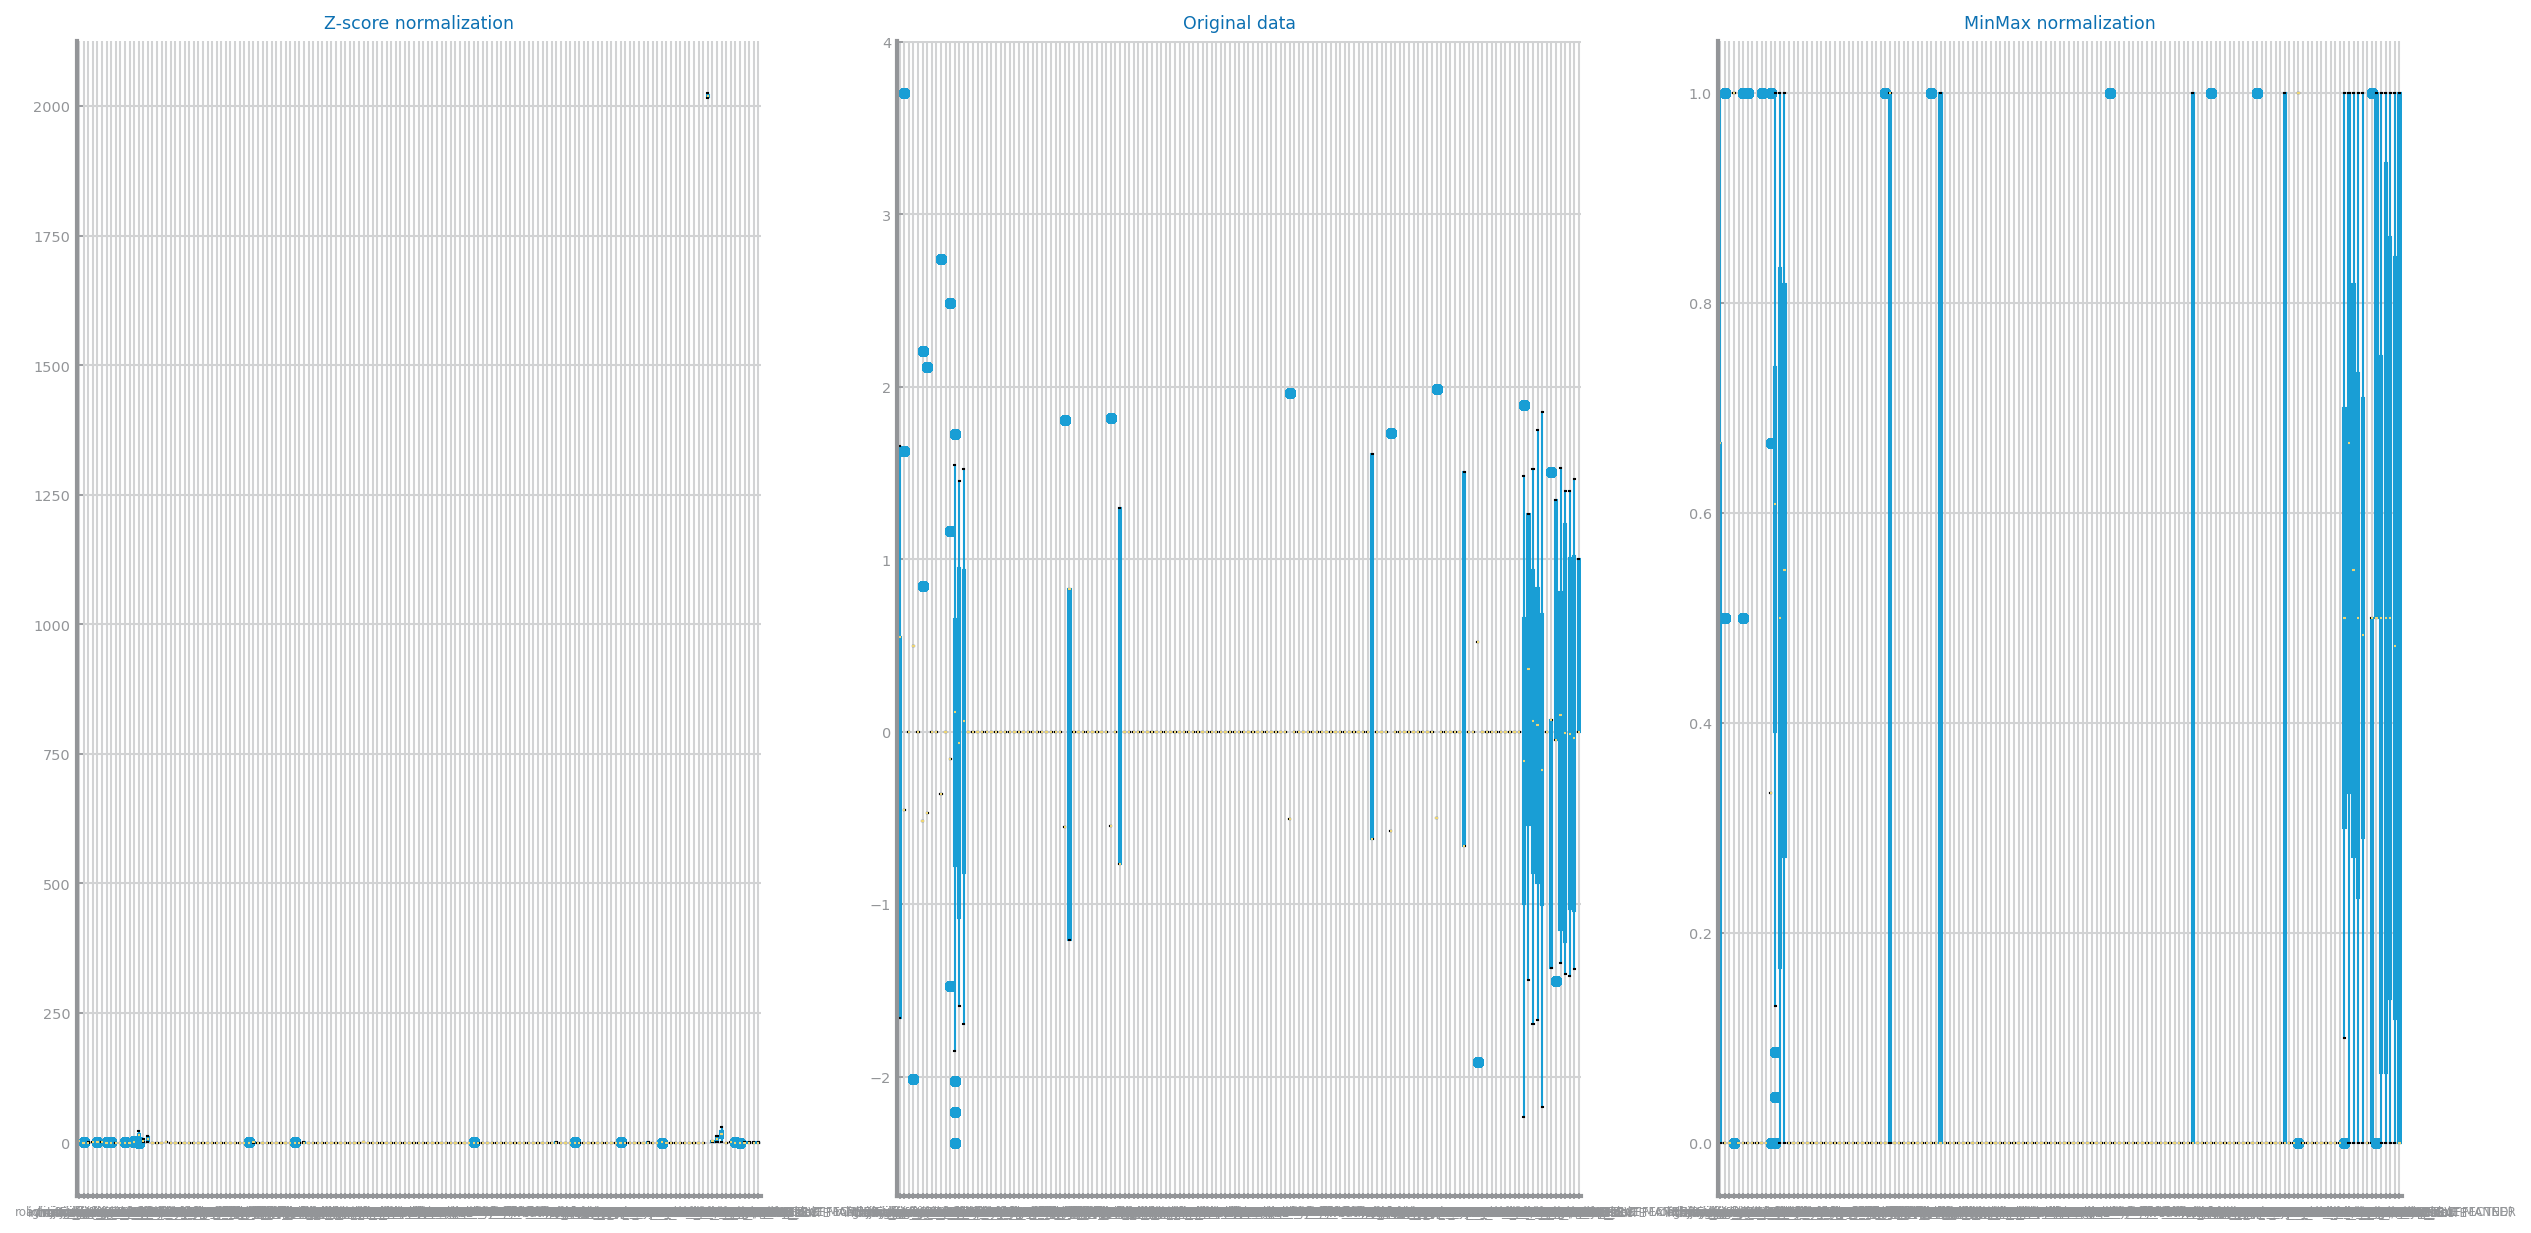

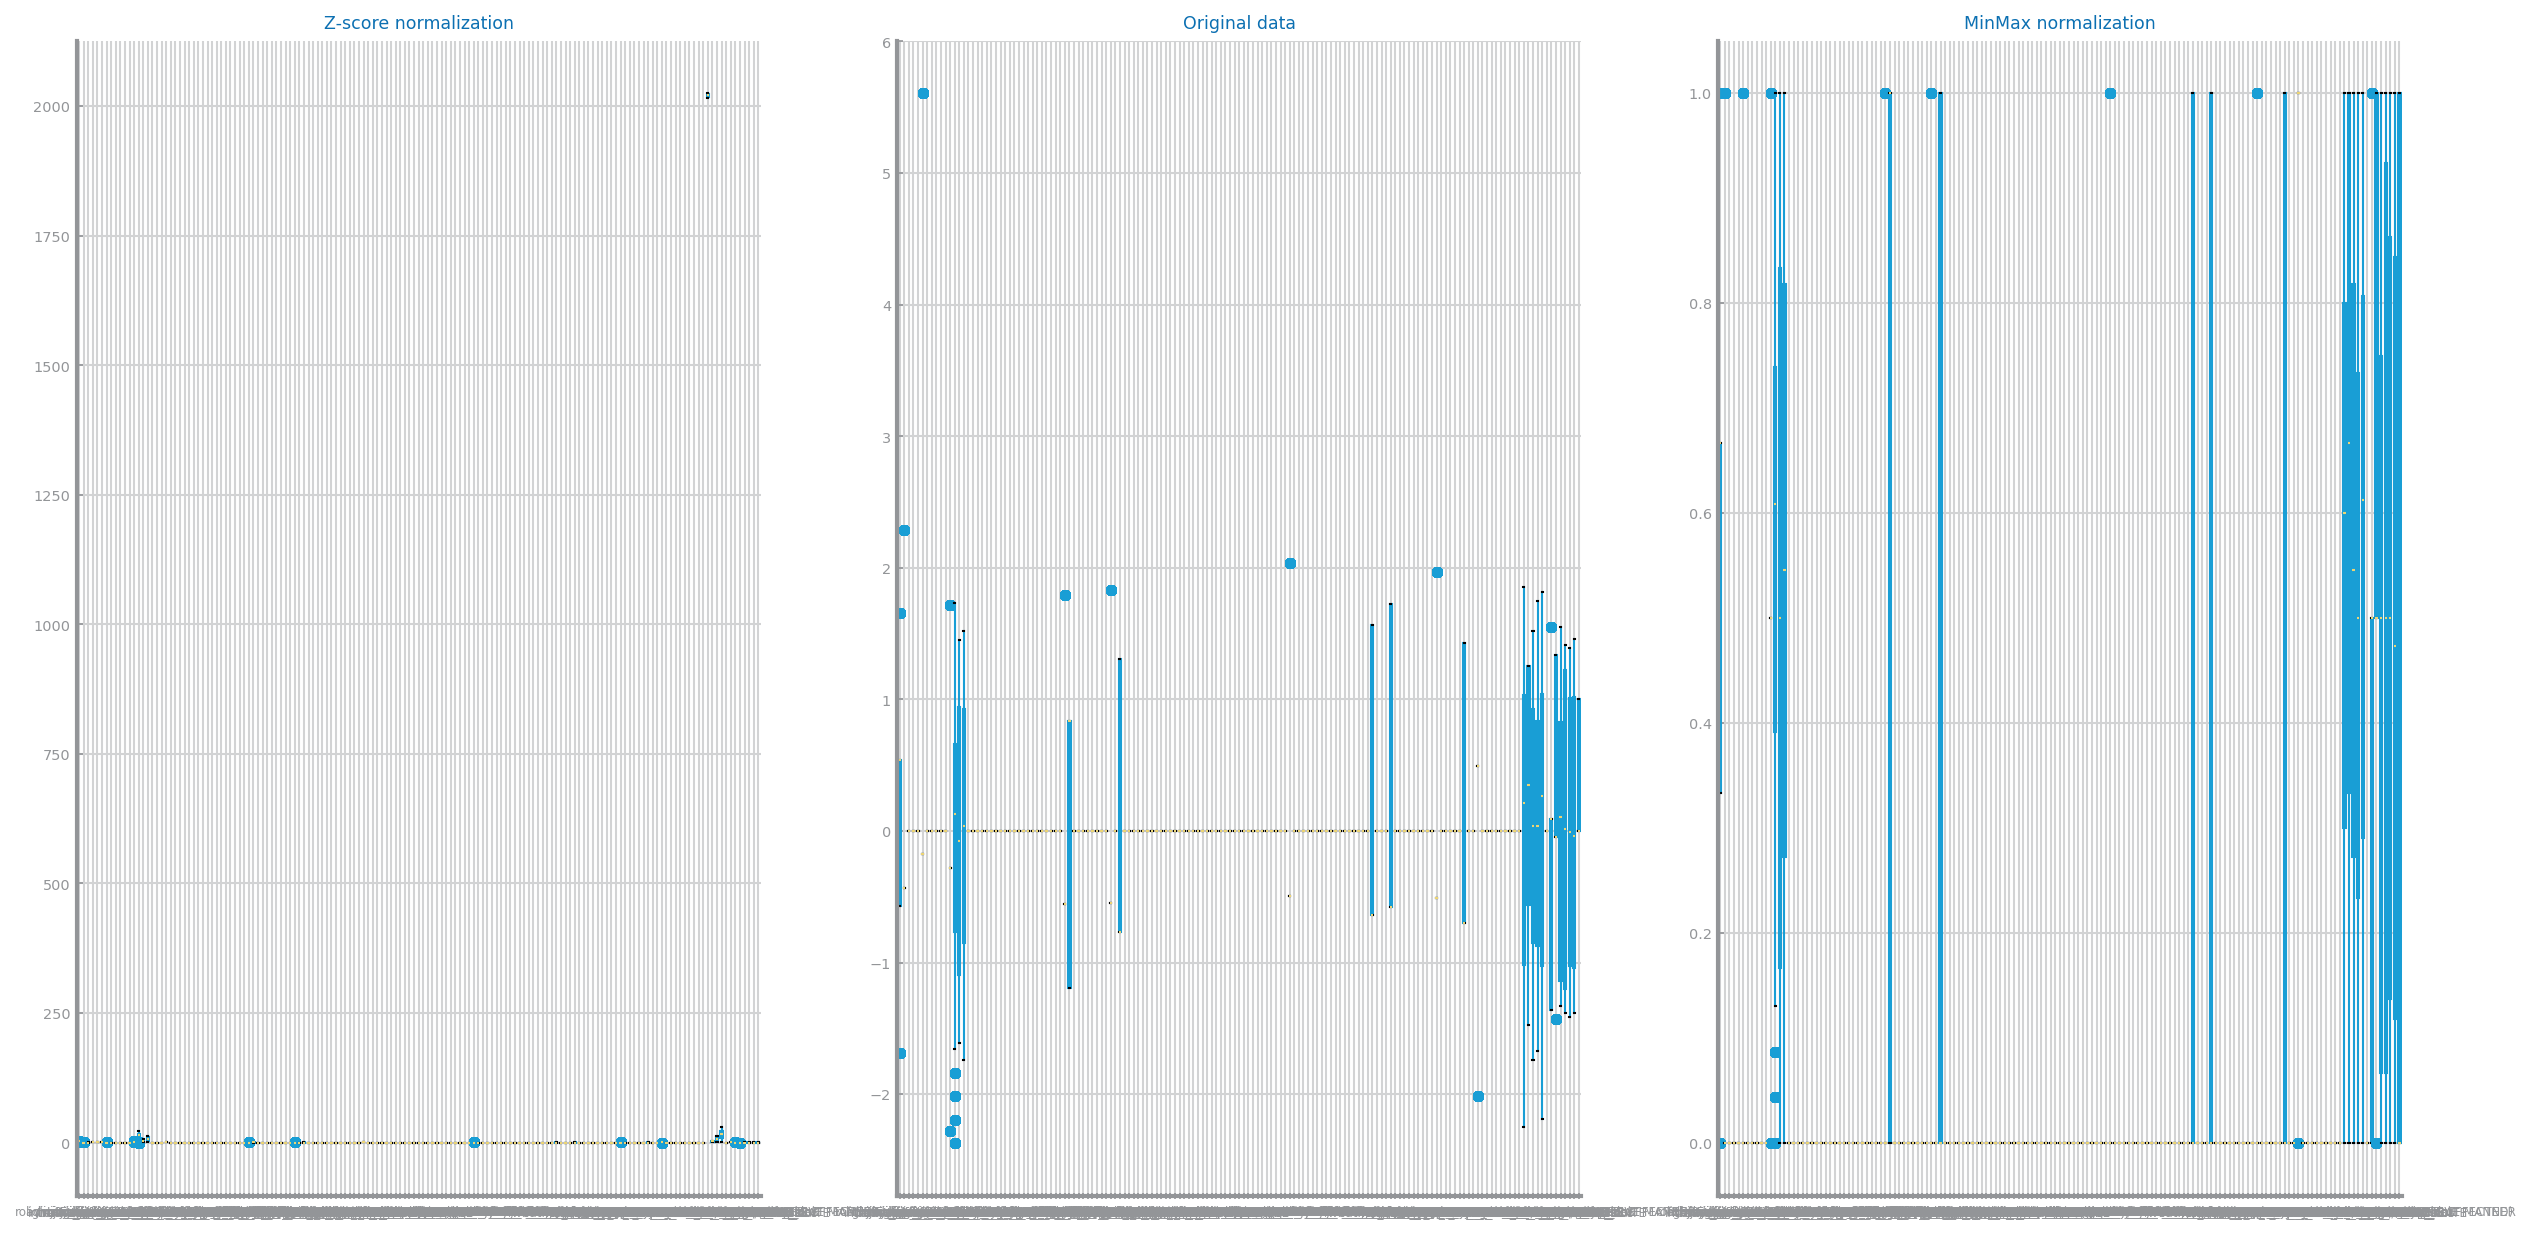

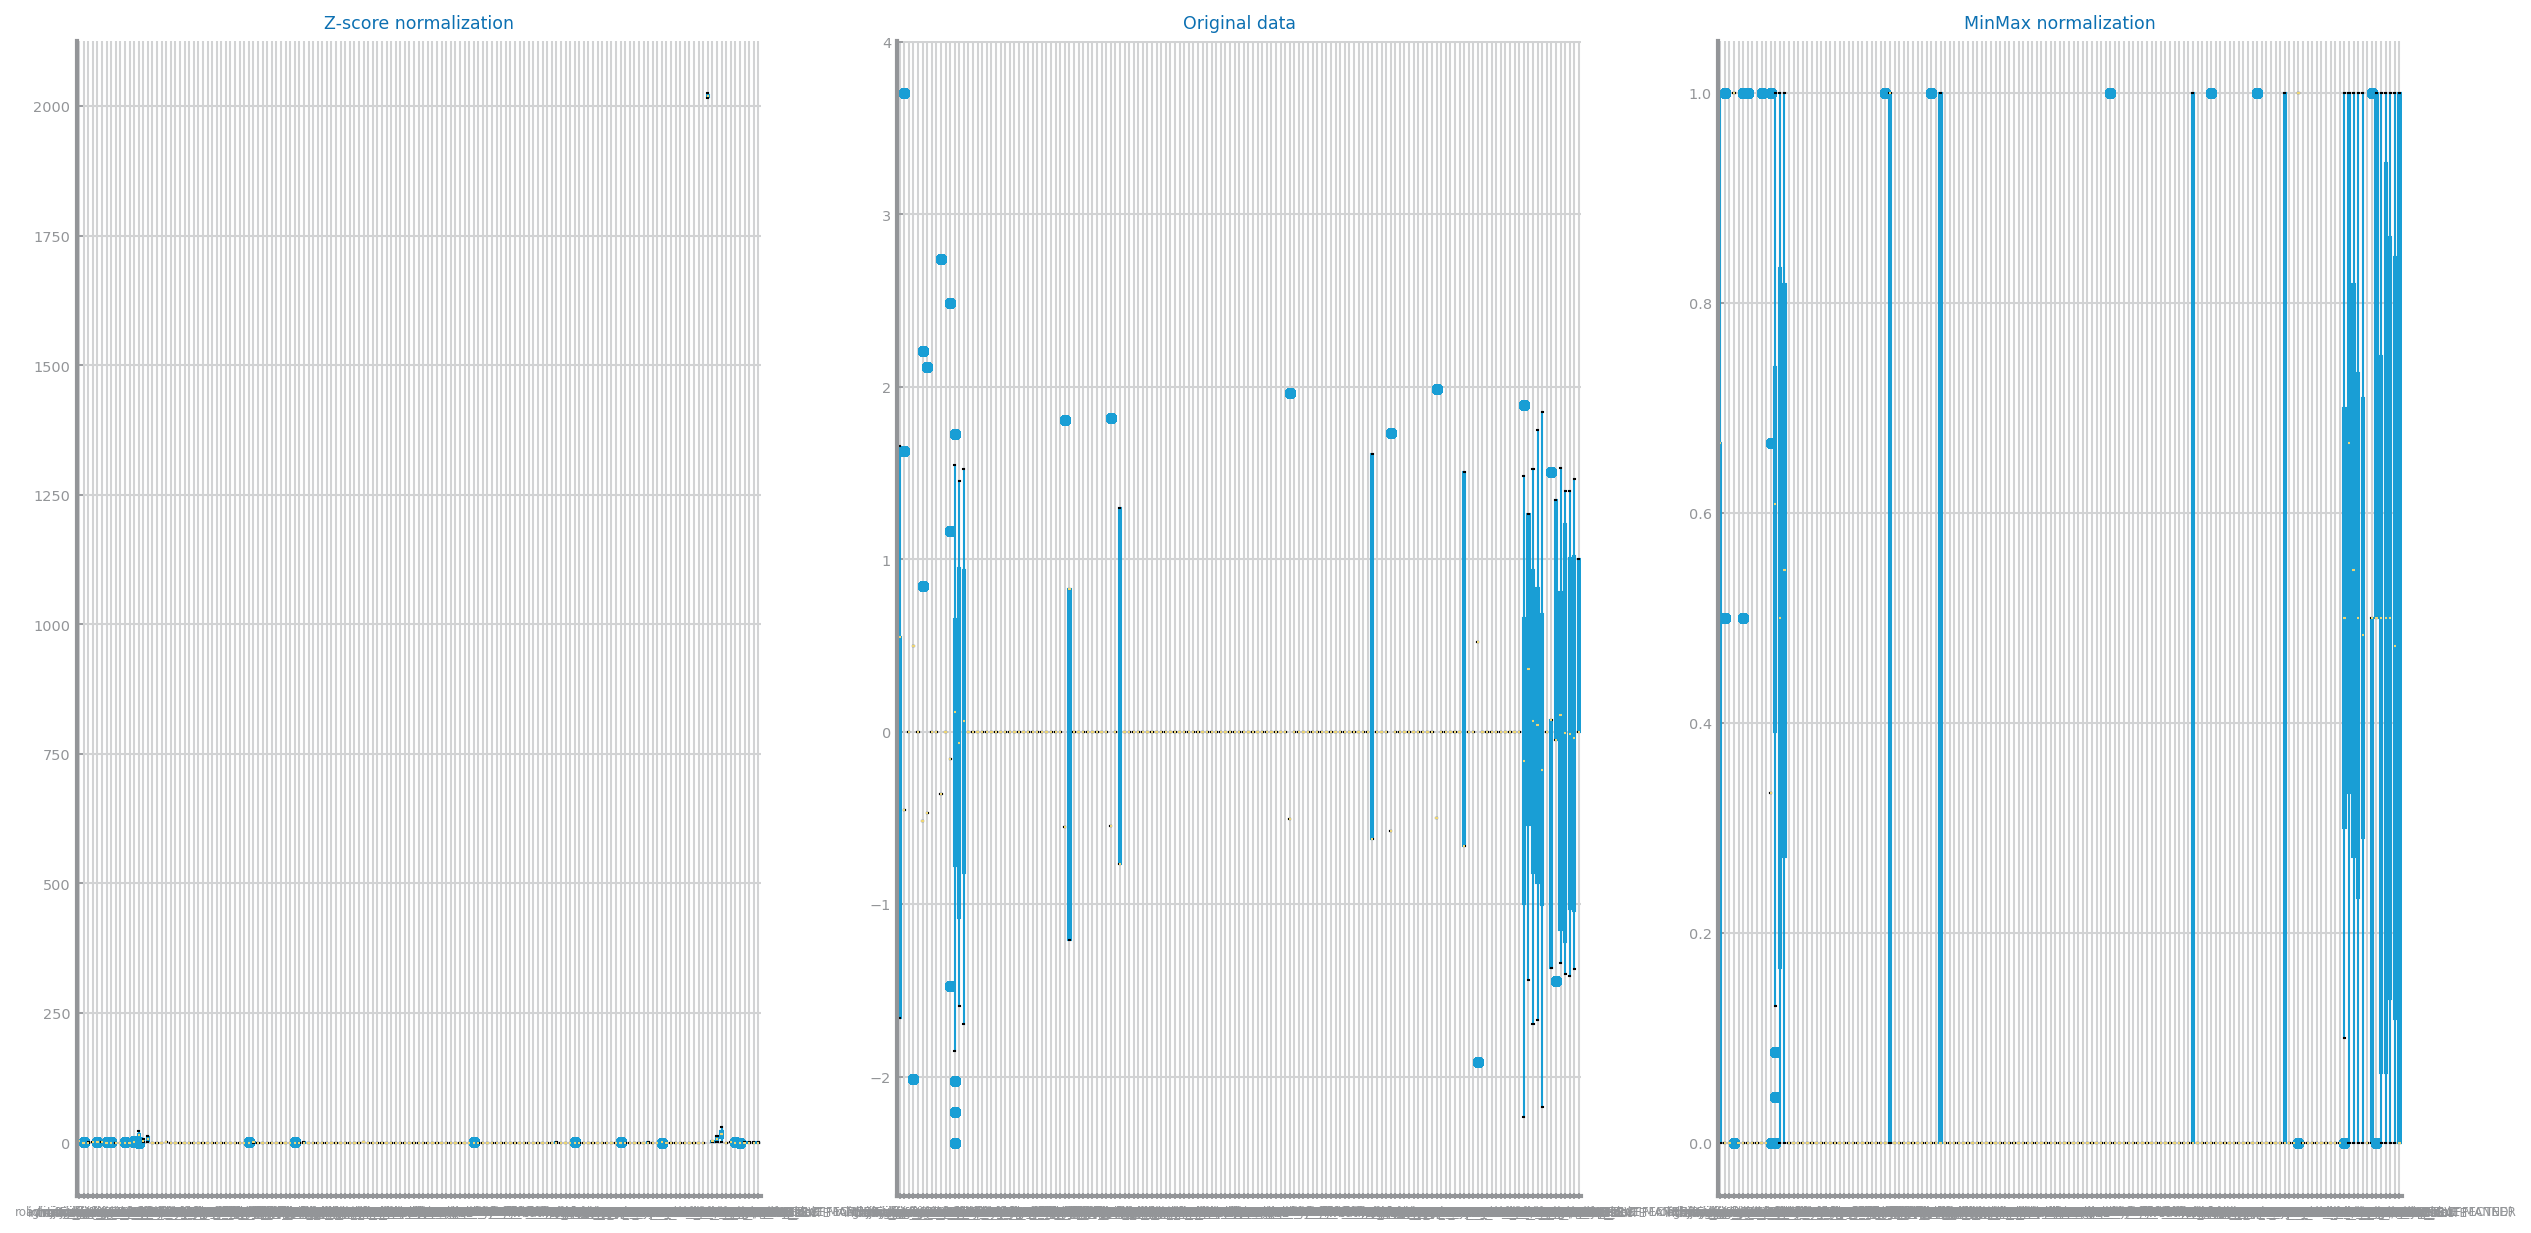

In [9]:
from matplotlib.pyplot import subplots, show
fig, axs = subplots(1, 3, figsize=(20, 10), squeeze=False)
axs[0, 1].set_title("Original data")
train_df_truncate.boxplot(ax=axs[0, 0])
axs[0, 0].set_title("Z-score normalization")
train_df_t_zscore.boxplot(ax=axs[0, 1])
axs[0, 2].set_title("MinMax normalization")
train_df_t_minmax.boxplot(ax=axs[0, 2])
show()

fig, axs = subplots(1, 3, figsize=(20, 10), squeeze=False)
axs[0, 1].set_title("Original data")
train_df_discard.boxplot(ax=axs[0, 0])
axs[0, 0].set_title("Z-score normalization")
train_df_d_zscore.boxplot(ax=axs[0, 1])
axs[0, 2].set_title("MinMax normalization")
train_df_d_minmax.boxplot(ax=axs[0, 2])
show()

fig, axs = subplots(1, 3, figsize=(20, 10), squeeze=False)
axs[0, 1].set_title("Original data")
train_df_fixed.boxplot(ax=axs[0, 0])
axs[0, 0].set_title("Z-score normalization")
train_df_f_zscore.boxplot(ax=axs[0, 1])
axs[0, 2].set_title("MinMax normalization")
train_df_f_minmax.boxplot(ax=axs[0, 2])
show()

## Evaluate

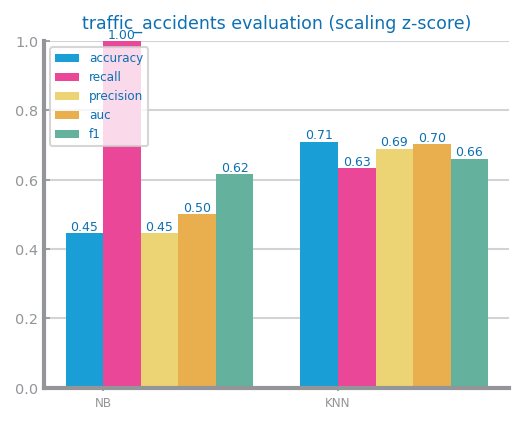

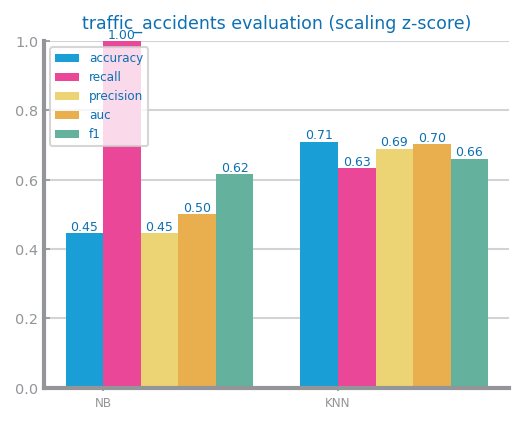

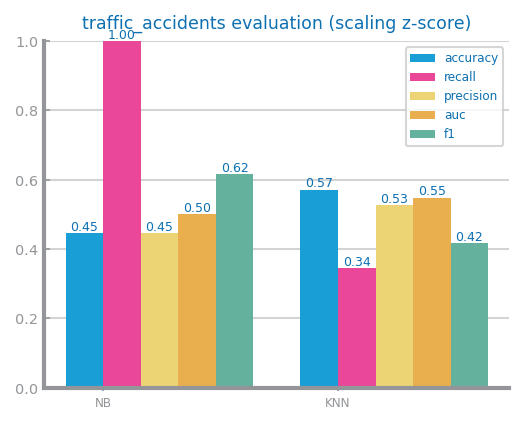

In [10]:
flags = [flag_outliers, flag_scaling]
evaluate(train_df_t_zscore, test_df_t_zscore, file_tag, target, outlier_strategy, "zscore", flags)
evaluate(train_df_f_zscore, test_df_f_zscore, file_tag, target, outlier_strategy, "zscore", flags)
evaluate(train_df_d_zscore, test_df_d_zscore, file_tag, target, outlier_strategy, "zscore", flags)

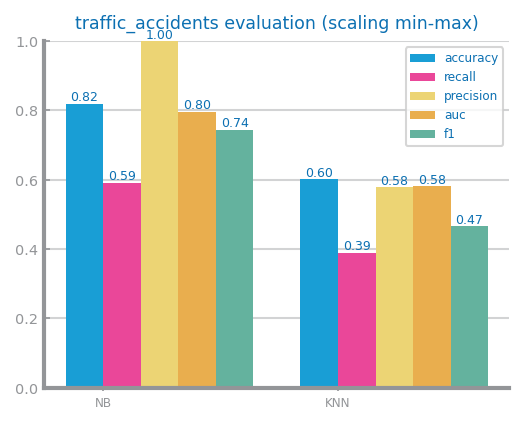

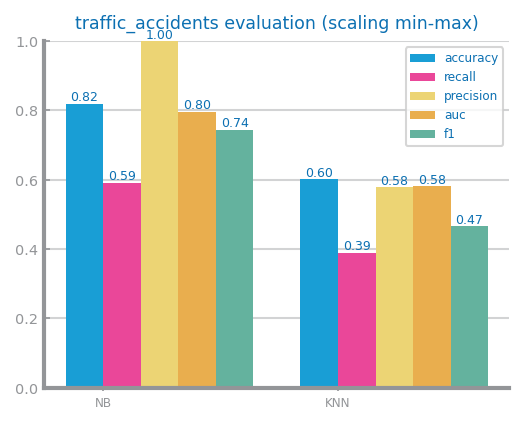

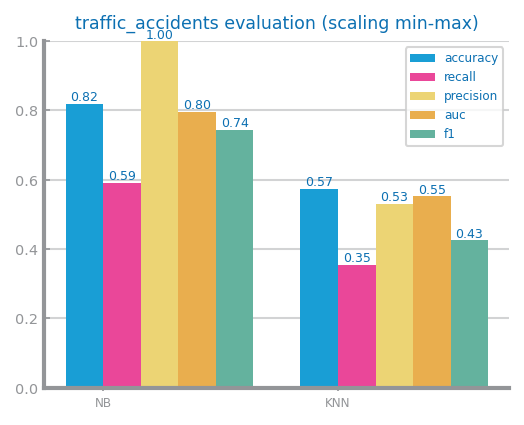

In [11]:
evaluate(train_df_t_minmax, test_df_t_minmax, file_tag, target, outlier_strategy, "minmax", flags)
evaluate(train_df_f_minmax, test_df_f_minmax, file_tag, target, outlier_strategy, "minmax", flags)
evaluate(train_df_d_minmax, test_df_d_minmax, file_tag, target, outlier_strategy, "minmax", flags)